In [127]:
# basic
import pandas as pd
import numpy as np
import ast
import json
import os
from sklearn.experimental import enable_halving_search_cv
from sklearn.utils.fixes import loguniform

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

#preprocessing/evaluation
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.feature_selection import SelectKBest, chi2

# models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB,BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC



In [113]:
# convert string to dictionary
def to_dict(attribute):
    try:
        if attribute != None:
            return ast.literal_eval(attribute)
        else:
            return ast.literal_eval("{}")
    except Exception as ex:
        print(ex)

In [114]:
# importing restaurants
restaurant = pd.read_csv('restaurant.csv')

In [115]:
# expand out attributes and make them their own columns
restaurant['attributes'] = restaurant['attributes'].replace(r'^\s*$', np.nan, regex=True)
restaurant['attributes'] = restaurant['attributes'].where(pd.notnull(restaurant['attributes']), None)
attributes_dict = [to_dict(x) for x in restaurant['attributes']]
attributes = pd.DataFrame(attributes_dict)

pd.set_option('display.max_columns', None)

In [116]:
# expand out nested dictionaries like GoodForMeal and Ambience
attributes['GoodForMeal'] = attributes['GoodForMeal'].where(pd.notnull(attributes['GoodForMeal']), None)
gfm_dict = [to_dict(x) for x in attributes['GoodForMeal']]
gfm = pd.json_normalize(gfm_dict)
# print(gfm)

attributes['Ambience'] = attributes['Ambience'].where(pd.notnull(attributes['Ambience']), None)
a_dict = [to_dict(x) for x in attributes['Ambience']]
a = pd.json_normalize(a_dict)
# print(a)

attributes['BusinessParking'] = attributes['BusinessParking'].where(pd.notnull(attributes['BusinessParking']), None)
bp_dict = [to_dict(x) for x in attributes['BusinessParking']]
bp = pd.json_normalize(bp_dict)
# print(bp)

attributes['BestNights'] = attributes['BestNights'].where(pd.notnull(attributes['BestNights']), None)
bn_dict = [to_dict(x) for x in attributes['BestNights']]
bn = pd.json_normalize(bn_dict)
bn = bn.rename(columns={'monday': 'monday_bn', 'tuesday': 'tuesday_bn', 
                        'wednesday': 'wednesday_bn', 'thursday': 'thursday_bn', 
                        'friday': 'friday_bn', 'saturday': 'saturday_bn', 'sunday': 'sunday_bn'})
# print(bn)

attributes['Music'] = attributes['Music'].where(pd.notnull(attributes['Music']), None)
m_dict = [to_dict(x) for x in attributes['Music']]
m = pd.json_normalize(m_dict)
# print(m)

attributes['DietaryRestrictions'] = attributes['DietaryRestrictions'].where(pd.notnull(attributes['DietaryRestrictions']), None)
dr_dict = [to_dict(x) for x in attributes['DietaryRestrictions']]
dr = pd.json_normalize(dr_dict)
# print(dr)

# drop col in attributes
attributes = attributes.drop(['GoodForMeal', 'Ambience', 'BusinessParking', 'BestNights', 'Music', 'DietaryRestrictions'], 
                             axis=1)

# fuse together
attributes = pd.concat([attributes, gfm, a, bp, bn, m, dr], axis=1)

attributes

RestaurantsDelivery OutdoorSeating BusinessAcceptsCreditCards  \
0                   False          False                      False   
1                    True           True                       True   
2                   False           True                       True   
3                    True           True                       True   
4                     NaN           None                        NaN   
...                   ...            ...                        ...   
52263                True            NaN                       True   
52264               False           True                       True   
52265                True          False                       True   
52266               False            NaN                       True   
52267                 NaN            NaN                        NaN   

      BikeParking RestaurantsPriceRange2 RestaurantsTakeOut ByAppointmentOnly  \
0            True                      1               True             False   
1           False                      1               True             False   
2             NaN                      1               True               NaN   
3             NaN                      1               True             False   
4             NaN                    NaN                NaN               NaN   
...           ...                    ...                ...               ...   
52263        True                      1               True               NaN   
52264        True                      1              False               NaN   
52265        True                      2               True               NaN   
52266        True                      1               True               NaN   
52267         NaN                      2               True               NaN   

          WiFi      Alcohol Caters RestaurantsAttire RestaurantsReservations  \
0      u'free'      u'none'   True               NaN                     NaN   
1        u'no'      u'none'  False         u'casual'                   False   
2      u'free'  u'full_bar'   True         u'casual'                   False   
3        u'no'      u'none'  False          'casual'                   False   
4          NaN       'none'    NaN               NaN                   False   
...        ...          ...    ...               ...                     ...   
52263      NaN          NaN   True               NaN                     NaN   
52264   'free'      u'none'  False          'casual'                   False   
52265  u'free'      u'none'   True          'casual'                   False   
52266      NaN       'none'   True               NaN                     NaN   
52267      NaN          NaN    NaN         u'casual'                     NaN   

      GoodForKids CoatCheck DogsAllowed RestaurantsTableService  \
0             NaN       NaN         NaN                     NaN   
1            True     False       False                   False   
2            True       NaN         NaN                     NaN   
3            True     False       False                   False   
4             NaN       NaN         NaN                     NaN   
...           ...       ...         ...                     ...   
52263         NaN       NaN         NaN                     NaN   
52264        True       NaN         NaN                     NaN   
52265        True       NaN         NaN                    True   
52266         NaN       NaN         NaN                     NaN   
52267        True       NaN         NaN                    True   

      RestaurantsGoodForGroups WheelchairAccessible  HasTV HappyHour  \
0                          NaN                  NaN    NaN       NaN   
1                         True                 True   True     False   
2                         True                  NaN   True       NaN   
3                        False                 True   True     False   
4                          NaN                  NaN   

In [117]:
# one hot encode attributes
df = pd.get_dummies(attributes)

counts = {}
for col in df:
    counts[col] = df[col].sum()
    
# sort
counts = sorted(counts.items(), key=lambda kv: kv[1], reverse=True)
# print(counts)

# drop any col with sum < 10000
for col in df:
    if df[col].sum() < 10000:
        df.drop(col, axis=1, inplace=True)

attributes = df
attributes

RestaurantsDelivery_False  RestaurantsDelivery_True  \
0                              1                         0   
1                              0                         1   
2                              1                         0   
3                              0                         1   
4                              0                         0   
...                          ...                       ...   
52263                          0                         1   
52264                          1                         0   
52265                          0                         1   
52266                          1                         0   
52267                          0                         0   

       OutdoorSeating_False  OutdoorSeating_True  \
0                         1                    0   
1                         0                    1   
2                         0                    1   
3                         0                    1   
4                         0                    0   
...                     ...                  ...   
52263                     0                    0   
52264                     0                    1   
52265                     1                    0   
52266                     0                    0   
52267                     0                    0   

       BusinessAcceptsCreditCards_True  BikeParking_True  \
0                                    0                 1   
1                                    1                 0   
2                                    1                 0   
3                                    1                 0   
4                                    0                 0   
...                                ...               ...   
52263                                1                 1   
52264                                1                 1   
52265                                1                 1   
52266                                1                 1   
52267                                0                 0   

       RestaurantsPriceRange2_1  RestaurantsPriceRange2_2  \
0                             1                         0   
1                             1                         0   
2                             1                         0   
3                             1                         0   
4                             0                         0   
...                         ...                       ...   
52263                         1                         0   
52264                         1                         0   
52265                         0                         1   
52266                         1                         0   
52267                         0                         1   

       RestaurantsTakeOut_True  WiFi_u'free'  WiFi_u'no'  Alcohol_u'full_bar'  \
0                            1             1           0                    0   
1                            1             0           1                    0   
2                            1             1           0                    1   
3                            1             0           1                    0   
4                            0             0           0                    0   
...                        ...           ...         ...                  ...   
52263                        1             0           0                    0   
52264                        0             0           0                    0   
52265                        1             1           0                    0   
52266                        1             0           0                    0   
52267                        1             0           0                    0   

       Alcohol_u'none'  Caters_False  Caters_True  RestaurantsAttire_'casual'  \
0                    1             0            1                           0   
1                    1             1            

In [118]:
# expand out categories and make them their own columns
# categories = pd.Series(restaurant['categories']).str.get_dummies(',')
# # drop columns that only contain zeros or 1
# categories = categories.loc[:, (categories != 0).any(axis=0)]
# categories

# expand out categories and make them their own columns
categories = pd.Series(restaurant['categories']).str.get_dummies(', ')

def toList(cat):
    return [x.strip() for x in cat.split(',')]

def toSeries(series):
    return pd.Series(x for _list in series for x in _list)

# categories
resCategories = restaurant['categories']
#categories
resCategories = resCategories.apply(toList)
resCategories = toSeries(resCategories)

cat = {}
for _, val in resCategories.items():
    if val in cat:
        cat[val] +=1
    else:
        cat.update({val:1})
        
cat = dict(sorted(cat.items(), key=lambda item: item[1]))

res = {key : val for key, val in cat.items() if not (isinstance(val, int) and (val < 1000))}

catKeys = list(res.keys())
catKeys.remove('Restaurants')
catKeys

categories = categories[catKeys]
categories

Food Trucks  Juice Bars & Smoothies  Tacos  Soup  Arts & Entertainment  \
0                0                       0      0     0                     0   
1                0                       0      0     0                     0   
2                0                       0      0     0                     0   
3                0                       0      0     0                     0   
4                1                       0      0     0                     0   
...            ...                     ...    ...   ...                   ...   
52263            0                       0      0     0                     0   
52264            0                       1      0     0                     0   
52265            0                       0      0     0                     0   
52266            1                       0      0     0                     0   
52267            0                       0      0     0                     0   

       Ice Cream & Frozen Yogurt  Beer  Wine & Spirits  Vegetarian  \
0                              0     0               0           0   
1                              1     0               0           0   
2                              0     0               0           0   
3                              1     0               0           0   
4                              0     0               0           0   
...                          ...   ...             ...         ...   
52263                          0     0               0           0   
52264                          0     0               0           0   
52265                          0     0               0           0   
52266                          0     0               0           0   
52267                          0     0               0           0   

       Mediterranean  Pubs  Cocktail Bars  Diners  Steakhouses  Asian Fusion  \
0                  0     0              0       0            0             0   
1                  0     0              0       0            0             0   
2                  0     1              0       0            0             0   
3                  0     0              0       0            0             0   
4                  0     0              0       0            0             0   
...              ...   ...            ...     ...          ...           ...   
52263              0     0              0       0            0             0   
52264              0     0              0       0            0             0   
52265              0     0              0       0            0             0   
52266              0     0              0       0            0             0   
52267              0     0              0       0            0             0   

       Barbeque  Sushi Bars  Sports Bars  Japanese  Desserts  Bakeries  \
0             0           0            0         0         0         1   
1             0           0            0         0         0         0   
2             0           0            0         0         0         0   
3             0           0            0         0         0         0   
4             0           0            0         0         0         0   
...         ...         ...          ...       ...       ...       ...   
52263         0           0            0         0         0         0   
52264         0           0            0         0         0         0   
52265         0           0            0         0         0         0   
52266         0           0            0         0         0         0   
52267         0           0            0         0         0         0   

       Specialty Food  Caterers  Delis  Cafes  Chicken Wings  Salad  \
0                   0         0      0      0              0      0   
1                   0         0      0      0              0      0   
2                   0         0      0      0              0      0   
3                   0         0      0      0              

In [119]:
# fuse into one whole table and drop attributes, categories
restaurant = restaurant.drop(["attributes", "categories", "hours"], axis=1)
restaurant = pd.concat([restaurant, attributes, categories], axis=1)
restaurant

Unnamed: 0             business_id                           name  \
0               3  MTSW4McQd7CbVtyjqoe9mw             St Honore Pastries   
1               5  CF33F8-E6oudUQ46HnavjQ                 Sonic Drive-In   
2               8  k0hlBqXX-Bt0vf1op7Jr1w          Tsevi's Pub And Grill   
3               9  bBDDEgkFA1Otx9Lfe7BZUQ                 Sonic Drive-In   
4              11  eEOYSgkmpB90uNA7lDOMRA          Vietnamese Food Truck   
...           ...                     ...                            ...   
52263      150325  l9eLGG9ZKpLJzboZq-9LRQ                           Wawa   
52264      150327  cM6V90ExQD6KMSU3rRB5ZA              Dutch Bros Coffee   
52265      150336  WnT9NIzQgLlILjPT0kEcsQ  Adelita Taqueria & Restaurant   
52266      150339  2O2K6SXPWv56amqxCECd4w                   The Plum Pit   
52267      150340  hn9Toz3s-Ei3uZPt7esExA          West Side Kebab House   

                     address             city state postal_code   latitude  \
0                935 Race St     Philadelphia    PA       19107  39.955505   
1              615 S Main St     Ashland City    TN       37015  36.269593   
2          8025 Mackenzie Rd           Affton    MO       63123  38.565165   
3        2312 Dickerson Pike        Nashville    TN       37207  36.208102   
4                        NaN        Tampa Bay    FL       33602  27.955269   
...                      ...              ...   ...         ...        ...   
52263        19 N Bishop Ave  Clifton Heights    PA       19018  39.925656   
52264    1181 N Milwaukee St            Boise    ID       83704  43.615401   
52265          1108 S 9th St     Philadelphia    PA       19147  39.935982   
52266        4405 Pennell Rd            Aston    DE       19014  39.856185   
52267  2470 Guardian Road NW         Edmonton    AB     T5T 1K8  53.509649   

        longitude  stars  review_count  is_open  RestaurantsDelivery_False  \
0      -75.155564    4.0            80        1                          1   
1      -87.058943    2.0             6        1                          0   
2      -90.321087    3.0            19        0                          1   
3      -86.768170    1.5            10        1                          0   
4      -82.456320    4.0            10        1                          0   
...           ...    ...           ...      ...                        ...   
52263  -75.310344    3.0            11        1                          0   
52264 -116.284689    4.0            33        1                          1   
52265  -75.158665    4.5            35        1                          0   
52266  -75.427725    4.5            14        1                          1   
52267 -113.675999    4.5            18        0                          0   

       RestaurantsDelivery_True  OutdoorSeating_False  OutdoorSeating_True  \
0                             0                     1                    0   
1                             1                     0                    1   
2                             0                     0                    1   
3                             1                     0                    1   
4                             0                     0                    0   
...                         ...                   ...                  ...   
52263                         1                     0                    0   
52264                         0                     0                    1   
52265                         1                     1                    0   
52266                         0                     0                    0   
52267                         0                     0                    0   

       BusinessAcceptsCreditCards_True  BikeParking_True  \
0                                    0                 1   
1                                    1                 0   
2                                    1                 0   
3                                    1     

In [120]:
# creating x
x = restaurant.loc[:, 'review_count':]
# can change to whatever amount we consider as "good"
y = restaurant['stars'].apply(lambda x: 1 if x>=4 else 0)

# split!
xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 0.3)

trainColumns = xTrain.columns

# normalize
scaler = MinMaxScaler()
# scaler = StandardScaler()
scaler.fit(xTrain)

xTrain = scaler.transform(xTrain)
xTest = scaler.transform(xTest)

In [121]:
# classifiers
n_cpu = os.cpu_count()

In [122]:
#finding best SVM features
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

In [123]:
#feature reduction

pca = PCA(n_components=60)
xTrain = pca.fit_transform(xTrain)
xTest = pca.transform(xTest)

In [110]:
#logistic regression

params = {'solver': ['newton-cg', 'lbfgs', 'sag'],
          'penalty': ['none', 'l2'],
          'C': np.logspace(-7, 5, num=500)
         }

grid = HalvingGridSearchCV(LogisticRegression(), param_grid=params, n_jobs=-1, cv=5, verbose=5)
grid.fit(xTrain, yTrain)
best_grid = grid.best_estimator_
yPred = best_grid.predict(xTest)
print(classification_report(yTest, yPred))
print(grid.best_params_)


n_iterations: 7
n_required_iterations: 8
n_possible_iterations: 7
min_resources_: 20
max_resources_: 36587
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3000
n_resources: 20
Fitting 5 folds for each of 3000 candidates, totalling 15000 fits


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

[CV 3/5] END C=1e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 1/5] END C=1e-07, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 4/5] END C=1e-07, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 3/5] END C=1e-07, penalty=none, solver=sag;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END C=1e-07, penalty=l2, solver=newton-cg;, score=(train=0.533, test=0.250) total time=   0.0s
[CV 3/5] END C=1e-07, penalty=l2, solver=lbfgs;, score=(train=0.625, test=0.333) total time=   0.0s
[CV 3/5] END C=1e-07, penalty=l2, solver=sag;, score=(train=0.500, test=0.000) total time=   0.0s
[CV 1/5] END C=1.0569345535579873e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END C=1.0569345535579873e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 4/5] END C=1.0569345535579873e-07, pen

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


enalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END C=1.5078450458610511e-06, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=1.5078450458610511e-06, penalty=none, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=1.5078450458610511e-06, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=1.5078450458610511e-06, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=1.5078450458610511e-06, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 2/5] END C=1.5078450458610511e-06, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=1.5078450458610511e-06, penalty=none, solver=lbfgs;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=1.5078450458610511e-06, penalty=none, solver=lbfgs;, 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

D C=1.8816944249705556e-06, penalty=l2, solver=sag;, score=(train=0.667, test=0.750) total time=   0.0s
[CV 2/5] END C=1.8816944249705556e-06, penalty=l2, solver=sag;, score=(train=0.533, test=0.250) total time=   0.0s
[CV 3/5] END C=1.8816944249705556e-06, penalty=l2, solver=sag;, score=(train=0.500, test=1.000) total time=   0.0s
[CV 4/5] END C=1.8816944249705556e-06, penalty=l2, solver=sag;, score=(train=0.500, test=0.333) total time=   0.0s
[CV 5/5] END C=1.8816944249705556e-06, penalty=l2, solver=sag;, score=(train=0.562, test=1.000) total time=   0.0s
[CV 1/5] END C=1.9888278569888116e-06, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END C=1.9888278569888116e-06, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=1.9888278569888116e-06, penalty=none, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=1.9888278569888116e-06, penalty=none, solver=newton-

re the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: C

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 4/5] END C=5.695226779712819e-06, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=5.695226779712819e-06, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=5.695226779712819e-06, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 2/5] END C=5.695226779712819e-06, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=5.695226779712819e-06, penalty=none, solver=lbfgs;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=5.695226779712819e-06, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=5.695226779712819e-06, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 1/5] END C=5.695226779712819e-06, penalty=none, solver=sag;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 2/5] END C=5.695226779712819e-06, penalty=none

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 3/5] END C=0.0003068837891917642, penalty=l2, solver=sag;, score=(train=0.500, test=1.000) total time=   0.0s
[CV 4/5] END C=0.0003068837891917642, penalty=l2, solver=sag;, score=(train=0.562, test=0.667) total time=   0.0s
[CV 5/5] END C=0.0003068837891917642, penalty=l2, solver=sag;, score=(train=0.562, test=1.000) total time=   0.0s
[CV 1/5] END C=0.0003243560807235811, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END C=0.0003243560807235811, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=0.0003243560807235811, penalty=none, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=0.0003243560807235811, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=0.0003243560807235811, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=0.0003243560807235811, penalty=no

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

penalty=none, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=0.0003829713914046281, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=0.0003829713914046281, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=0.0003829713914046281, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 2/5] END C=0.0003829713914046281, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=0.0003829713914046281, penalty=none, solver=lbfgs;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=0.0003829713914046281, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=0.0003829713914046281, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 1/5] END C=0.0003829713914046281, penalty=none, solver=sag;, score=(train=1.00

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

, solver=sag;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=0.0003428231493733971, penalty=none, solver=sag;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=0.0003428231493733971, penalty=none, solver=sag;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=0.0003428231493733971, penalty=none, solver=sag;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=0.0003428231493733971, penalty=l2, solver=newton-cg;, score=(train=0.667, test=0.750) total time=   0.0s
[CV 2/5] END C=0.0003428231493733971, penalty=l2, solver=newton-cg;, score=(train=0.533, test=0.250) total time=   0.0s
[CV 3/5] END C=0.0003428231493733971, penalty=l2, solver=newton-cg;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 2/5] END C=0.0004278214201767617, penalty=l2, solver=sag;, score=(train=0.533, test=0.250) total time=   0.0s
[CV 3/5] END C=0.0004278214201767617, penalty=l2, solver=sag;, score=(train=0.688, test=0.333) total time=   0.0

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

[CV 3/5] END C=0.01653624407094182, penalty=l2, solver=lbfgs;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 4/5] END C=0.01653624407094182, penalty=l2, solver=lbfgs;, score=(train=0.938, test=0.000) total time=   0.0s
[CV 5/5] END C=0.01653624407094182, penalty=l2, solver=lbfgs;, score=(train=0.562, test=1.000) total time=   0.0s
[CV 1/5] END C=0.01653624407094182, penalty=l2, solver=sag;, score=(train=0.667, test=0.750) total time=   0.0s
[CV 2/5] END C=0.01653624407094182, penalty=l2, solver=sag;, score=(train=0.800, test=0.250) total time=   0.0s
[CV 3/5] END C=0.01653624407094182, penalty=l2, solver=sag;, score=(train=0.938, test=1.000) total time=   0.0s
[CV 4/5] END C=0.01653624407094182, penalty=l2, solver=sag;, score=(train=0.938, test=0.000) total time=   0.0s
[CV 5/5] END C=0.01653624407094182, penalty=l2, solver=sag;, score=(train=0.562, test=1.000) total time=   0.0s
[CV 2/5] END C=0.020636177678638564, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.750) 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

[CV 1/5] END C=0.020636177678638564, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END C=0.020636177678638564, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=0.020636177678638564, penalty=none, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=0.020636177678638564, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=0.020636177678638564, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=0.020636177678638564, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 3/5] END C=0.02436540009125466, penalty=none, solver=sag;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=0.02436540009125466, penalty=none, solver=sag;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=0.02436540009125466, penalty=none, 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

in=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=0.9417766006869519, penalty=none, solver=sag;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=0.9417766006869519, penalty=none, solver=sag;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=0.9417766006869519, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=1.111967731120698, penalty=l2, solver=lbfgs;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=1.111967731120698, penalty=l2, solver=lbfgs;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 5/5] END C=1.111967731120698, penalty=l2, solver=lbfgs;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=1.111967731120698, penalty=l2, solver=sag;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END C=1.111967731120698, penalty=l2, solver=sag;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 3/5] END C=1.111967731120698, penalty=l2, solver=sag;, s

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

[CV 5/5] END C=0.9953962309984243, penalty=l2, solver=sag;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=1.052068671023623, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END C=1.052068671023623, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=1.052068671023623, penalty=none, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=1.052068671023623, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=1.052068671023623, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=1.052068671023623, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 2/5] END C=1.052068671023623, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=1.052068671023623, penalty=none, solver=lbfgs;, score=(t

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 3/5] END C=1.4666708663439685, penalty=none, solver=sag;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=1.4666708663439685, penalty=none, solver=sag;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=1.4666708663439685, penalty=none, solver=sag;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=1.4666708663439685, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END C=1.4666708663439685, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 3/5] END C=1.4666708663439685, penalty=l2, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=1.4666708663439685, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 5/5] END C=1.4666708663439685, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=1.4666708663439685, penalty=l2, solver=lbfgs;, score=(train=1

[CV 4/5] END C=93.3125117507824, penalty=l2, solver=sag;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=1.3876647909813071, penalty=none, solver=sag;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=1.3876647909813071, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END C=1.3876647909813071, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 3/5] END C=1.3876647909813071, penalty=l2, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=1.3876647909813071, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.000) total time=   0.0s
[CV 5/5] END C=1.3876647909813071, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=1.3876647909813071, penalty=l2, solver=lbfgs;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END C=1.3876647909813071, penalty=l2, solver=lbfgs;, score=(train=1.000

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

[CV 2/5] END C=70.74559422819878, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=70.74559422819878, penalty=l2, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=70.74559422819878, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=70.74559422819878, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=70.74559422819878, penalty=l2, solver=lbfgs;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END C=70.74559422819878, penalty=l2, solver=lbfgs;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=70.74559422819878, penalty=l2, solver=lbfgs;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=70.74559422819878, penalty=l2, solver=lbfgs;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=70.74559422819878, penalty=l2, solver=lbfgs;, score=(train=1.000, test=0.

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

est=1.000) total time=   0.0s
[CV 4/5] END C=765.1869154570818, penalty=none, solver=sag;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=765.1869154570818, penalty=none, solver=sag;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=765.1869154570818, penalty=l2, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END C=765.1869154570818, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=765.1869154570818, penalty=l2, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=765.1869154570818, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=765.1869154570818, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=765.1869154570818, penalty=l2, solver=lbfgs;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END C=765.1869154570818, penalty=l2, solver=l

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

[CV 2/5] END C=130.08537010905732, penalty=none, solver=sag;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=130.08537010905732, penalty=none, solver=sag;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=130.08537010905732, penalty=none, solver=sag;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=130.08537010905732, penalty=none, solver=sag;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=130.08537010905732, penalty=l2, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END C=130.08537010905732, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=130.08537010905732, penalty=l2, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=130.08537010905732, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=130.08537010905732, penalty=l2, solver=newton-cg;, score=(train=1

re the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: C

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

----------
iter: 1
n_candidates: 1000
n_resources: 60
Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

[CV 5/5] END C=3606.7349515740316, penalty=l2, solver=lbfgs;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=3606.7349515740316, penalty=l2, solver=sag;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 3/5] END C=4500.975129608051, penalty=none, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=4500.975129608051, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=4500.975129608051, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=4500.975129608051, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 2/5] END C=4500.975129608051, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=4500.975129608051, penalty=none, solver=lbfgs;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=4500.975129608051, penalty=none, solver=lbfgs;, score=(train=1.00

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

0, test=0.333) total time=   0.0s
[CV 5/5] END C=4500.975129608051, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 1/5] END C=4500.975129608051, penalty=none, solver=sag;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 2/5] END C=4500.975129608051, penalty=none, solver=sag;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=4500.975129608051, penalty=none, solver=sag;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=4500.975129608051, penalty=none, solver=sag;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=4500.975129608051, penalty=none, solver=sag;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=4500.975129608051, penalty=l2, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END C=4500.975129608051, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=4500.975129608051, penalty=l2, solver=newton-

[CV 1/5] END C=75815.76457522118, penalty=l2, solver=sag;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END C=75815.76457522118, penalty=l2, solver=sag;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=75815.76457522118, penalty=l2, solver=sag;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=75815.76457522118, penalty=l2, solver=sag;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=75815.76457522118, penalty=l2, solver=sag;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=80132.30128396886, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END C=80132.30128396886, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=80132.30128396886, penalty=none, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=80132.30128396886, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.33

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

[CV 3/5] END C=6631.981202212662, penalty=l2, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=6631.981202212662, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=6631.981202212662, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=6631.981202212662, penalty=l2, solver=lbfgs;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END C=6631.981202212662, penalty=l2, solver=lbfgs;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=6631.981202212662, penalty=l2, solver=lbfgs;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=6631.981202212662, penalty=l2, solver=lbfgs;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=6631.981202212662, penalty=l2, solver=lbfgs;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=6631.981202212662, penalty=l2, solver=sag;, score=(train=1.000, test=0.500) t

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

otal time=   0.0s
[CV 2/5] END C=6631.981202212662, penalty=l2, solver=sag;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=6631.981202212662, penalty=l2, solver=sag;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=6631.981202212662, penalty=l2, solver=sag;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=6631.981202212662, penalty=l2, solver=sag;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=7009.570091165632, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 2/5] END C=7009.570091165632, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=7009.570091165632, penalty=none, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=7009.570091165632, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=7009.570091165632, penalty=none, solver=newton-cg;, sco

113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

) total time=   0.0s
[CV 1/5] END C=71731.74944465628, penalty=l2, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 2/5] END C=71731.74944465628, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=71731.74944465628, penalty=l2, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=71731.74944465628, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=71731.74944465628, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=71731.74944465628, penalty=l2, solver=lbfgs;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 2/5] END C=71731.74944465628, penalty=l2, solver=lbfgs;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=71731.74944465628, penalty=l2, solver=lbfgs;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=71731.74944465628, penalty=l2, solver=lbfgs;, sc

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

[CV 2/5] END C=9771.921283717997, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=9771.921283717997, penalty=none, solver=newton-cg;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=9771.921283717997, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=9771.921283717997, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 1/5] END C=9771.921283717997, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 2/5] END C=9771.921283717997, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.750) total time=   0.0s
[CV 3/5] END C=9771.921283717997, penalty=none, solver=lbfgs;, score=(train=1.000, test=1.000) total time=   0.0s
[CV 4/5] END C=9771.921283717997, penalty=none, solver=lbfgs;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 5/5] END C=9771.921283717997, penalty=none, solver=lbfgs;, score=(tr

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 2/5] END C=954.9044557518077, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.1s
[CV 3/5] END C=954.9044557518077, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.0s
[CV 4/5] END C=954.9044557518077, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.0s
[CV 5/5] END C=954.9044557518077, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.0s
[CV 1/5] END C=1009.2715146305698, penalty=l2, solver=sag;, score=(train=1.000, test=0.583) total time=   0.0s
[CV 2/5] END C=1009.2715146305698, penalty=l2, solver=sag;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 3/5] END C=1009.2715146305698, penalty=l2, solver=sag;, score=(train=1.000, test=0.545) total time=   0.0s
[CV 4/5] END C=1009.2715146305698, penalty=l2, solver=sag;, score=(train=1.000, test=0.364) total time=   0.0s
[CV 5/5] END C=1009.2715146305698, penalty=l2, solver=sag;, score=(train=1.000, test

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

=0.636) total time=   0.0s
[CV 1/5] END C=31260.072430687036, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.1s
[CV 3/5] END C=854.7984528840423, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.0s
[CV 4/5] END C=854.7984528840423, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.0s
[CV 5/5] END C=854.7984528840423, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.0s
[CV 1/5] END C=4.981897519205165e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 2/5] END C=4.981897519205165e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 3/5] END C=4.981897519205165e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.0s
[CV 4/5] END C=4.981897519205165e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.0s
[CV 5/5] END

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=75815.76457522118, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.583) total time=   0.0s
[CV 2/5] END C=75815.76457522118, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 3/5] END C=75815.76457522118, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.1s
[CV 4/5] END C=75815.76457522118, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.0s
[CV 5/5] END C=75815.76457522118, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.727) total time=   0.1s
[CV 1/5] END C=80132.30128396886, penalty=none, solver=sag;, score=(train=1.000, test=0.583) total time=   0.0s
[CV 2/5] END C=80132.30128396886, penalty=none, solver=sag;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 3/5] END C=80132.30128396886, penalty=none, solver=sag;, score=(train=1.000, test=0.545) total time=   0.0s
[CV 4/5] END C=80132.30128396886, penalty=none, solver=sag;, score=(train=1.000, tes

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

t=0.364) total time=   0.0s
[CV 5/5] END C=80132.30128396886, penalty=none, solver=sag;, score=(train=1.000, test=0.818) total time=   0.0s
[CV 1/5] END C=1.318986896198669e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 2/5] END C=1.318986896198669e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.1s
[CV 3/5] END C=1.318986896198669e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.2s
[CV 4/5] END C=1.318986896198669e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.1s
[CV 5/5] END C=1.318986896198669e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 2/5] END C=352.44730038015877, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.1s
[CV 3/5] END C=352.44730038015877, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.1s
[CV 4/5] END

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

g;, score=(train=1.000, test=0.545) total time=   0.0s
[CV 4/5] END C=0.010618229410993846, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.0s
[CV 5/5] END C=0.010618229410993846, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 1/5] END C=0.010046250617173402, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.1s
[CV 2/5] END C=0.010046250617173402, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 2/5] END C=0.020636177678638564, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.1s
[CV 3/5] END C=0.020636177678638564, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.1s
[CV 4/5] END C=0.020636177678638564, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.1s
[CV 5/5] END C=0.020636177678638564, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.8

113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10

18) total time=   0.1s
[CV 1/5] END C=0.0033192662047331896, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 2/5] END C=0.0033192662047331896, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 1/5] END C=0.004378068629038167, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.1s
[CV 2/5] END C=0.004378068629038167, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.1s
[CV 3/5] END C=0.004378068629038167, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.1s
[CV 4/5] END C=0.004378068629038167, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.1s
[CV 5/5] END C=0.004378068629038167, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 1/5] END C=0.02575263326771199, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.1s
[CV 5/5]

 penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/li

 END C=24.705040554568203, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 1/5] END C=0.0041422324724838975, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.1s
[CV 2/5] END C=0.0041422324724838975, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.1s
[CV 3/5] END C=0.0041422324724838975, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.1s
[CV 4/5] END C=0.0041422324724838975, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.1s
[CV 5/5] END C=0.0041422324724838975, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 4/5] END C=26.11161100917462, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.1s
[CV 5/5] END C=26.11161100917462, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 1/5] END C=0.0037079876291681727, penal

[CV 4/5] END C=3812.082795843888, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.0s
[CV 5/5] END C=3812.082795843888, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.0s
[CV 1/5] END C=6.724427423484249e-06, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.0s
[CV 2/5] END C=6.724427423484249e-06, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 3/5] END C=6.724427423484249e-06, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.0s
[CV 4/5] END C=6.724427423484249e-06, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.0s
[CV 5/5] END C=6.724427423484249e-06, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.2s
[CV 1/5] END C=3812.082795843888, penalty=l2, solver=sag;, score=(train=1.000, test=0.583) total time=   0.1s
[CV 2/5] END C=3812.082795843888, penalty=l2

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(


score=(train=1.000, test=0.333) total time=   0.1s
[CV 1/5] END C=0.001615908753895919, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.1s
[CV 2/5] END C=0.001615908753895919, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.1s
[CV 3/5] END C=0.001615908753895919, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.1s
[CV 4/5] END C=0.001615908753895919, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.1s
[CV 5/5] END C=0.001615908753895919, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 1/5] END C=0.033967385822722095, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.1s
[CV 5/5] END C=2.8504263208534377, penalty=l2, solver=sag;, score=(train=1.000, test=0.636) total time=   0.1s
[CV 1/5] END C=56.69007271207434, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=  

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

----------
iter: 2
n_candidates: 334
n_resources: 180
Fitting 5 folds for each of 334 candidates, totalling 1670 fits


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno


[CV 1/5] END C=116.44806183726855, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.1s
[CV 2/5] END C=116.44806183726855, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 3/5] END C=116.44806183726855, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.1s
[CV 4/5] END C=116.44806183726855, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.1s
[CV 5/5] END C=116.44806183726855, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 5/5] END C=1.052068671023623, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 1/5] END C=123.07798025066633, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.1s
[CV 2/5] END C=123.07798025066633, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.1s
[CV 3/5] END C=123.07798025066633, penalty=none,

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STO

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

[CV 4/5] END C=0.5721567555063252, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.1s
[CV 5/5] END C=0.5721567555063252, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 1/5] END C=0.16010644613183178, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.1s
[CV 2/5] END C=0.16010644613183178, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 3/5] END C=0.16010644613183178, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.1s
[CV 4/5] END C=0.16010644613183178, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.1s
[CV 3/5] END C=0.5121755443364241, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.1s
[CV 4/5] END C=0.5121755443364241, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.1s
[CV 5/5] END C=0.5121755443364241, penalty=n

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

[CV 2/5] END C=110.17528137883873, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 3/5] END C=110.17528137883873, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.1s
[CV 4/5] END C=110.17528137883873, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.0s
[CV 3/5] END C=0.052898930760981455, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.1s
[CV 4/5] END C=0.052898930760981455, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.1s
[CV 5/5] END C=0.052898930760981455, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 1/5] END C=2.2841122073038256, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.1s
[CV 2/5] END C=2.2841122073038256, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.1s
[CV 3/5] END C=2.2841122073038256, penalty

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

[CV 5/5] END C=0.0009288292250172499, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 1/5] END C=0.06977299649665537, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.1s
[CV 2/5] END C=0.06977299649665537, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.2s
[CV 3/5] END C=0.06977299649665537, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.1s
[CV 5/5] END C=0.0005051342468816766, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 1/5] END C=0.06601449092734883, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.667) total time=   0.1s
[CV 2/5] END C=0.06601449092734883, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.1s
[CV 3/5] END C=0.06601449092734883, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.1s
[CV 4/5] END C=0.06601449092734883, 

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

----------
iter: 3
n_candidates: 112
n_resources: 540
Fitting 5 folds for each of 112 candidates, totalling 560 fits


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

----------
iter: 4
n_candidates: 38
n_resources: 1620
Fitting 5 folds for each of 38 candidates, totalling 190 fits


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

[CV 2/5] END C=3228.628202536727, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.1s
[CV 3/5] END C=3228.628202536727, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.545) total time=   0.0s
[CV 4/5] END C=3228.628202536727, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.0s
[CV 5/5] END C=3228.628202536727, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.727) total time=   0.0s
[CV 1/5] END C=26.11161100917462, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.500) total time=   0.0s
[CV 2/5] END C=26.11161100917462, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.333) total time=   0.0s
[CV 4/5] END C=30.830314565682706, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.364) total time=   0.1s
[CV 5/5] END C=30.830314565682706, penalty=l2, solver=newton-cg;, score=(train=1.000, test=0.818) total time=   0.1s
[CV 1/5] END C=2587.1740785959187, penalty=l2, solver=newton-cg;, scor

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

----------
iter: 5
n_candidates: 13
n_resources: 4860
Fitting 5 folds for each of 13 candidates, totalling 65 fits


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

----------
iter: 6
n_candidates: 5
n_resources: 14580
Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

[CV 1/5] END C=36909.16910662782, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.528) total time=   0.1s
[CV 2/5] END C=36909.16910662782, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.1s
[CV 3/5] END C=36909.16910662782, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.571) total time=   0.2s
[CV 4/5] END C=36909.16910662782, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.771) total time=   0.3s
[CV 5/5] END C=36909.16910662782, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.714) total time=   0.1s
[CV 1/5] END C=4.180637241455762e-05, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.528) total time=   0.1s
[CV 2/5] END C=4.180637241455762e-05, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.1s
[CV 2/5] END C=3.955436244734702e-05, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.2s
[CV 3/5] END C=3.955436244734702e-05, penalt

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will igno

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      8665
           1       0.68      0.64      0.66      7016

    accuracy                           0.71     15681
   macro avg       0.70      0.70      0.70     15681
weighted avg       0.70      0.71      0.70     15681

{'C': 0.027218847945751797, 'penalty': 'none', 'solver': 'newton-cg'}
[CV 1/5] END C=2.1511234301821673e-05, penalty=none, solver=newton-cg;, score=(train=0.727, test=0.673) total time=   0.3s
[CV 2/5] END C=2.1511234301821673e-05, penalty=none, solver=newton-cg;, score=(train=0.757, test=0.713) total time=   0.2s
[CV 3/5] END C=2.1511234301821673e-05, penalty=none, solver=newton-cg;, score=(train=0.735, test=0.666) total time=   0.3s
[CV 4/5] END C=2.1511234301821673e-05, penalty=none, solver=newton-cg;, score=(train=0.737, test=0.721) total time=   0.2s
[CV 2/5] END C=1.4734543096198344e-07, penalty=none, solver=newton-cg;, score=(train=0.757, test=0.713) total t

[CV 1/5] END C=954.9044557518077, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.528) total time=   0.1s
[CV 2/5] END C=954.9044557518077, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.1s
[CV 4/5] END C=1066.7339377348592, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.771) total time=   0.2s
[CV 5/5] END C=1066.7339377348592, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.714) total time=   0.1s
[CV 1/5] END C=3.742366290721977e-05, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.528) total time=   0.1s
[CV 2/5] END C=3.742366290721977e-05, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.1s
[CV 3/5] END C=3.742366290721977e-05, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.571) total time=   0.1s
[CV 4/5] END C=3.742366290721977e-05, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.771) total time=   0.1s
[CV 5/5] END C=3.742366290721977e-05, 

[CV 4/5] END C=1.1171106505048242e-07, penalty=none, solver=newton-cg;, score=(train=0.806, test=0.729) total time=   0.1s
[CV 1/5] END C=1.0569345535579873e-07, penalty=none, solver=newton-cg;, score=(train=0.761, test=0.574) total time=   0.1s
[CV 2/5] END C=1.0569345535579873e-07, penalty=none, solver=newton-cg;, score=(train=0.826, test=0.639) total time=   0.0s
[CV 2/5] END C=0.0001864408533970487, penalty=none, solver=newton-cg;, score=(train=0.826, test=0.639) total time=   0.1s
[CV 3/5] END C=0.0001864408533970487, penalty=none, solver=newton-cg;, score=(train=0.799, test=0.701) total time=   0.1s
[CV 3/5] END C=252.81661443314954, penalty=none, solver=newton-cg;, score=(train=0.799, test=0.701) total time=   0.1s
[CV 4/5] END C=252.81661443314954, penalty=none, solver=newton-cg;, score=(train=0.806, test=0.729) total time=   0.1s
[CV 3/5] END C=0.0001579053314474176, penalty=none, solver=newton-cg;, score=(train=0.799, test=0.701) total time=   0.2s
[CV 4/5] END C=0.0001579053

[CV 2/5] END C=1.943466926536022e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.1s
[CV 3/5] END C=1.943466926536022e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.571) total time=   0.1s
[CV 4/5] END C=1.943466926536022e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.771) total time=   0.1s
[CV 5/5] END C=1.943466926536022e-07, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.714) total time=   0.1s
[CV 1/5] END C=0.00010716676480328633, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.528) total time=   0.1s
[CV 2/5] END C=0.00010716676480328633, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.750) total time=   0.1s
[CV 3/5] END C=0.00010716676480328633, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.571) total time=   0.1s
[CV 4/5] END C=0.00010716676480328633, penalty=none, solver=newton-cg;, score=(train=1.000, test=0.771) total time=   0.1s
[CV 5/5] END C=0.000

In [111]:
print(classification_report(yTest, yPred))
print(grid.best_params_)

              precision    recall  f1-score   support

           0       0.72      0.76      0.74      8665
           1       0.68      0.64      0.66      7016

    accuracy                           0.71     15681
   macro avg       0.70      0.70      0.70     15681
weighted avg       0.70      0.71      0.70     15681

{'C': 0.027218847945751797, 'penalty': 'none', 'solver': 'newton-cg'}


In [95]:
#NB: 
#works best with minmax

#clf = GaussianNB()
# clf.fit(xTrain, yTrain)
# yPred = clf.predict(xTest)
# print("f1: ", f1_score(yTest, yPred))
# print("accuracy: ", accuracy_score(yTest, yPred))
# print("precision: ", precision_score(yTest, yPred))
# print("recall: ", recall_score(yTest, yPred))

n_classes = np.unique(yTrain)

# bernoulli = BernoulliNB()

# params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0],
#           'fit_prior': [True, False],
#           'class_prior': [None, [0.5,]* len(n_classes), ],
#           'binarize': [None, 0.0, 8.5, 10.0]
#          }

# grid = HalvingGridSearchCV(bernoulli, param_grid=params, n_jobs=-1, cv=5, verbose=5)
# grid.fit(xTrain, yTrain)
# best_grid = grid.best_estimator_
# yPred = best_grid.predict(xTest)
# print(classification_report(yTest, yPred))
# print(grid.best_params_)

# gaussian = GaussianNB()

# params = {
#             'priors': [None, [0.5,]* len(n_classes),],
#             'var_smoothing': [1e-9, 1e-6, 1e-12],
#          }

# grid = HalvingGridSearchCV(gaussian, param_grid=params, n_jobs=-1, cv=5, verbose=5)
# grid.fit(xTrain, yTrain)
# best_grid = grid.best_estimator_
# yPred = best_grid.predict(xTest)
# print(classification_report(yTest, yPred))
# print(grid.best_params_)
    
# multinomial = MultinomialNB()

# params = {'alpha': [0.01, 0.1, 0.5, 1.0, 10.0, ],
#           'fit_prior': [True, False],
#           'class_prior': [None, [0.5,]* len(n_classes), ]
#          }

# grid = HalvingGridSearchCV(multinomial, param_grid=params, n_jobs=-1, cv=5, verbose=5)
# grid.fit(xTrain, yTrain)
# best_grid = grid.best_estimator_
# yPred = best_grid.predict(xTest)
# print(classification_report(yTest, yPred))
# print(grid.best_params_)

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 4065
max_resources_: 36587
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 20
n_resources: 4065
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 1
n_candidates: 7
n_resources: 12195
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 2
n_candidates: 3
n_resources: 36585
Fitting 5 folds for each of 3 candidates, totalling 15 fits
              precision    recall  f1-score   support

           0       0.71      0.66      0.68      8665
           1       0.61      0.66      0.64      7016

    accuracy                           0.66     15681
   macro avg       0.66      0.66      0.66     15681
weighted avg       0.66      0.66      0.66     15681

{'alpha': 0.01, 'class_prior': [0.5, 0.5], 'fit_prior': True}


In [124]:
#SVM:
# clf = SVC()

# param_grid = {'C': [0.1, 1, 10, 100, 1000], 
#               'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
#               'kernel': ['rbf', 'poly', 'sigmoid']}

# grid = GridSearchCV(clf, param_grid, refit=True, verbose=3, cv=3)
# grid.fit(xTrain, yTrain)
# print(grid.best_params_)
# print(grid.best_estimator_)
# grid_predictions = grid.predict(xTest)
# print(classification_report(yTest, grid_predictions))

# clf.fit(xTrain, yTrain)
# yPred = clf.predict(xTest)
# print(classification_report(yTest, yPred))

# print("accuracy: ", accuracy_score(yTest, yPred))
# print("f1: ", f1_score(yTest, yPred))
# print("precision: ", precision_score(yTest, yPred))
# print("recall: ", recall_score(yTest, yPred))

clf = SVC(C=1, gamma=.01, kernel='rbf')
clf.fit(xTrain, yTrain)
yPred = clf.predict(xTest)

print(classification_report(yTest, yPred, digits=3))

              precision    recall  f1-score   support

           0      0.724     0.774     0.748      8631
           1      0.697     0.638     0.666      7050

    accuracy                          0.713     15681
   macro avg      0.710     0.706     0.707     15681
weighted avg      0.712     0.713     0.711     15681



/usr/local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


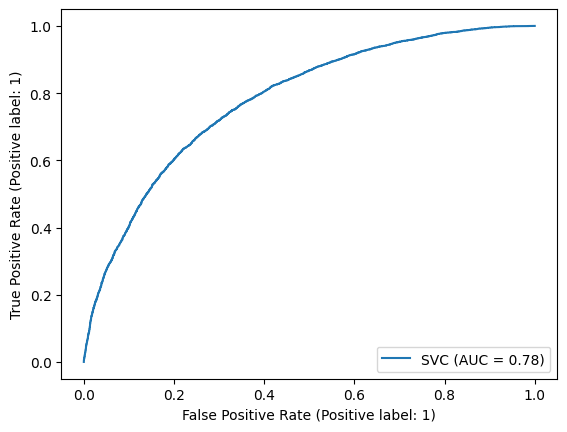

In [130]:
# fpr_pca, tpr_pca, _ = metrics.roc_curve(yTest, yPred)
# auc = metrics.roc_auc_score(yTest, yPred)
# plt.plot(fpr_pca,tpr_pca,label="AUC" + str(auc))
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('ROC curve normalized and PCA')
# plt.legend(loc="lower right")
# #plt.savefig("roc.png")
# plt.show()

metrics.plot_roc_curve(clf, xTest, yTest)

In [25]:
#Random Forests

param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}

clf = RandomForestClassifier()
grid_search = RandomizedSearchCV(estimator = clf, param_distributions = param_grid, random_state=42, n_iter = 20,
                          cv = 5, n_jobs = n_cpu-1, verbose = 2)
grid_search.fit(xTrain, yTrain)
grid_search.best_params_
best_grid = grid_search.best_estimator_
yPred = best_grid.predict(xTest)
print(classification_report(yTest, yPred))

# clf = RandomForestClassifier()
# clf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = n_cpu-1)
# clf_random.fit(xTrain, yTrain)
# print(clf_random.best_params_)


# param_grid = {
#     'bootstrap': [True],
#     'max_depth': [80, 90, 100, 110],
#     'max_features': [2, 3],
#     'min_samples_leaf': [3, 4, 5],
#     'min_samples_split': [8, 10, 12],
#     'n_estimators': [100, 200, 300, 1000]
# }
# clf = RandomForestClassifier()
# grid_search = GridSearchCV(estimator = clf, param_grid = param_grid, 
#                           cv = 3, n_jobs = n_cpu-1, verbose = 2)
# grid_search.fit(xTrain, yTrain)
# grid_search.best_params_
# best_grid = grid_search.best_estimator_
# yPred = best_grid.predict(xTest)
# print(classification_report(yTest, yPred))

# clf = RandomForestClassifier()
# clf.fit(xTrain, yTrain)
# yPred = clf.predict(xTest)
# print(classification_report(yTest, yPred))

# importances = clf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

# forest_importances = pd.Series(importances, index=x.columns).nlargest(10)
# print(forest_importances)

# # Figure size
# fig, ax = plt.subplots(figsize=(16,9))

# # horizontal bar plot
# ax.barh(forest_importances.index, forest_importances.values)

# # remove axes splines
# for s in ['top', 'bottom', 'left', 'right']:
#     ax.spines[s].set_visible(False)
    
# # Remove x, y Ticks
# ax.xaxis.set_ticks_position('none')
# ax.yaxis.set_ticks_position('none')

# # Add padding between axes and labels
# ax.xaxis.set_tick_params(pad = 5)
# ax.yaxis.set_tick_params(pad = 10)


# # Add x, y gridlines
# ax.grid(visible = True, color ='grey',
#         linestyle ='-.', linewidth = 0.5,
#         alpha = 0.2)
 
# # Show top values
# ax.invert_yaxis()
 
# # Add annotation to bars
# for i in ax.patches:
#     plt.text(i.get_width()+0.2, i.get_y()+0.5,
#              str(round((i.get_width()), 2)),
#              fontsize = 10, fontweight ='bold',
#              color ='grey') 

# # add Plot Title
# ax.set_title('Feature importances using MDI', loc ='left', )

# ax.set_xlabel("Mean Decrease in Impurity")
 
 
# Show Plot
# plt.show()

# print("accuracy: ", accuracy_score(yTest, yPred))
# print("f1: ", f1_score(yTest, yPred))
# print("precision: ", precision_score(yTest, yPred))
# print("recall: ", recall_score(yTest, yPred))

Fitting 5 folds for each of 20 candidates, totalling 100 fits
              precision    recall  f1-score   support

           0       0.74      0.77      0.75      8631
           1       0.70      0.66      0.68      7050

    accuracy                           0.72     15681
   macro avg       0.72      0.72      0.72     15681
weighted avg       0.72      0.72      0.72     15681

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   9.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  11.3s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.3min
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=3, min_samples_split=10, n_estimators=200; total time=  31.1s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_s

[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   9.1s
[CV] END bootstrap=True, max_depth=60, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=  11.4s
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.3min
[CV] END bootstrap=True, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=1000; total time= 1.1min
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  56.3s
[CV] END bootstrap=True, max_depth=80, max_features=sqrt, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=  56.3s
[CV] END bootstrap=False, max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=1800; total time= 1.5min
[CV] END bootstrap=False, max_depth=50, 

In [28]:
print(best_grid)

RandomForestClassifier(max_depth=30, min_samples_leaf=2, n_estimators=200)


In [96]:
clf = RandomForestClassifier(max_depth=30, min_samples_leaf=2, n_estimators=200)
clf.fit(xTrain, yTrain)
yPred = clf.predict(xTest)
print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76      8665
           1       0.71      0.66      0.69      7016

    accuracy                           0.73     15681
   macro avg       0.72      0.72      0.72     15681
weighted avg       0.73      0.73      0.73     15681

[CV 2/5] END alpha=0.1, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.667, test=0.647) total time=   0.0s
[CV 3/5] END alpha=0.1, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.657, test=0.654) total time=   0.0s
[CV 3/5] END alpha=10.0, binarize=0.0, class_prior=[0.5, 0.5], fit_prior=False;, score=(train=0.657, test=0.655) total time=   0.0s
[CV 4/5] END alpha=10.0, binarize=0.0, class_prior=[0.5, 0.5], fit_prior=False;, score=(train=0.656, test=0.639) total time=   0.0s
[CV 5/5] END alpha=10.0, binarize=0.0, class_prior=[0.5, 0.5], fit_prior=False;, score=(train=0.674, test=0.659) total time=   0.0s
[CV 5/5] END alpha=10.0, bi

[CV 3/5] END alpha=0.5, binarize=0.0, class_prior=[0.5, 0.5], fit_prior=True;, score=(train=0.657, test=0.654) total time=   0.0s
[CV 4/5] END alpha=0.5, binarize=0.0, class_prior=[0.5, 0.5], fit_prior=True;, score=(train=0.656, test=0.638) total time=   0.0s
[CV 3/5] END alpha=0.01, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.657, test=0.654) total time=   0.0s
[CV 4/5] END alpha=0.01, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.655, test=0.638) total time=   0.0s
[CV 5/5] END alpha=0.01, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.674, test=0.659) total time=   0.0s
[CV 5/5] END alpha=0.5, binarize=0.0, class_prior=[0.5, 0.5], fit_prior=False;, score=(train=0.674, test=0.659) total time=   0.0s
[CV 1/5] END alpha=1.0, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.655, test=0.665) total time=   0.0s
[CV 2/5] END alpha=1.0, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.667, test=0.647) 

[CV 5/5] END alpha=0.1, binarize=0.0, class_prior=[0.5, 0.5], fit_prior=False;, score=(train=0.674, test=0.659) total time=   0.0s
[CV 1/5] END alpha=10.0, binarize=0.0, class_prior=[0.5, 0.5], fit_prior=False;, score=(train=0.654, test=0.665) total time=   0.0s
[CV 2/5] END alpha=10.0, binarize=0.0, class_prior=[0.5, 0.5], fit_prior=False;, score=(train=0.667, test=0.647) total time=   0.0s
[CV 4/5] END alpha=10.0, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.656, test=0.639) total time=   0.0s
[CV 5/5] END alpha=10.0, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.674, test=0.659) total time=   0.0s
[CV 1/5] END alpha=10.0, binarize=0.0, class_prior=[0.5, 0.5], fit_prior=True;, score=(train=0.654, test=0.665) total time=   0.0s
[CV 1/5] END alpha=0.5, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.661, test=0.648) total time=   0.0s
[CV 2/5] END alpha=0.5, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.656, tes

[CV 2/5] END alpha=0.1, binarize=0.0, class_prior=[0.5, 0.5], fit_prior=True;, score=(train=0.667, test=0.647) total time=   0.0s
[CV 1/5] END alpha=0.5, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.654, test=0.665) total time=   0.0s
[CV 2/5] END alpha=0.5, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.667, test=0.647) total time=   0.0s
[CV 3/5] END alpha=0.5, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.657, test=0.654) total time=   0.0s
[CV 4/5] END alpha=0.01, binarize=0.0, class_prior=[0.5, 0.5], fit_prior=True;, score=(train=0.655, test=0.638) total time=   0.0s
[CV 5/5] END alpha=0.01, binarize=0.0, class_prior=[0.5, 0.5], fit_prior=True;, score=(train=0.674, test=0.659) total time=   0.0s
[CV 1/5] END alpha=0.5, binarize=0.0, class_prior=[0.5, 0.5], fit_prior=False;, score=(train=0.654, test=0.665) total time=   0.0s
[CV 3/5] END alpha=1.0, binarize=0.0, class_prior=None, fit_prior=False;, score=(train=0.657, test=0.6

In [13]:
#pearson correlation
def pearson_corr(x, y):
    x['label'] = y
    xcorr = x.corr().abs()
    #setting up matplotlib
    f, ax = plt.subplots(figsize=(25,25))

    #generating mask
    mask = np.triu(np.ones_like(xcorr, dtype=bool))

    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    sns.heatmap(xcorr, annot=True, mask=mask, cmap=cmap)
    plt.savefig("Corr_Heatmap.png")

    #selecting best features
    bestfeatures = SelectKBest(k=5)
    fit=bestfeatures.fit(x, y)

    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x.columns)

    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ['Specs', 'Score']